In [60]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
%matplotlib inline
import os
import matplotlib.pyplot as plt

## Load In the Data

In [45]:


base_skin_dir = "/Users/14128.DESKTOP-F7009KQ/projects/ImageClassification-main/data"
skin_df = pd.read_csv(os.path.join(base_skin_dir, "hmnist_64_64_RBG.csv")) # load in the data


In [46]:
skin_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
0,191,152,194,191,153,195,192,149,192,194,...,185,154,180,186,156,184,182,152,173,2
1,24,13,23,24,14,28,37,24,46,61,...,26,15,29,27,15,28,24,13,25,2
2,185,129,140,192,136,151,198,142,156,198,...,152,120,138,144,113,123,115,81,84,2
3,24,11,19,36,19,30,64,38,50,91,...,27,13,16,25,12,16,24,9,14,2
4,138,94,117,158,113,138,178,133,161,191,...,140,106,118,108,77,92,67,40,55,2


In [47]:
X = skin_df.drop("label", axis=1).values
label = skin_df["label"].values

In [48]:
X.shape, label.shape

((10015, 12288), (10015,))

## Scaling and Split Data into Train, Validation and Test set

In [49]:
X_mean = np.mean(X)
X_std = np.std(X)

X = (X - X_mean)/X_std

In [50]:
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, label, test_size=0.1,random_state=0)

In [51]:
X_train_orig.shape, X_test.shape, y_train_orig.shape, y_test.shape

((9013, 12288), (1002, 12288), (9013,), (1002,))

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, test_size=0.2, random_state=1)

In [53]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7210, 12288), (1803, 12288), (7210,), (1803,))

## Reshape the Data to Input in CNN

In [54]:
X_train = X_train.reshape(X_train.shape[0], *(64, 64, 3))
X_val = X_val.reshape(X_val.shape[0], *(64, 64, 3))
X_test = X_test.reshape(X_test.shape[0], *(64, 64, 3))

In [55]:
X_train.shape, X_val.shape, X_test.shape

((7210, 64, 64, 3), (1803, 64, 64, 3), (1002, 64, 64, 3))

In [56]:
y_train.shape

(7210,)

In [57]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [58]:
y_train.shape, y_val.shape, y_test.shape

((7210, 7), (1803, 7), (1002, 7))

## CNN Model

In [61]:
# Our input feature map is 64x64x3: 64x64 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(64, 64, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model
model = Model(img_input, output)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

C:\Users\14128.DESKTOP-F7009KQ\projects\ImageClassification-main\hi\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [62]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        1849

## Define Data Generator for Data Augmentation and Learning Rate Adaptive Reduction to Prevent Overfitting

In [63]:
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [64]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [65]:
batch_size = 64
epochs = 30
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

C:\Users\14128.DESKTOP-F7009KQ\AppData\Local\Temp\ipykernel_15748\3666111815.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/30



112/112 [==============================] - ETA: 0s - loss: 0.9817 - accuracy: 0.6641WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 21s 168ms/step - loss: 0.9817 - accuracy: 0.6641 - val_loss: 0.9285 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 2/30
112/112 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.6914WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 161ms/step - loss: 0.8523 - accuracy: 0.6914 - val_loss: 0.8157 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 3/30
112/112 [==============================] - ETA: 0s - loss: 0.8113 - accuracy: 0.7058WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 158ms/step - loss: 0.8113 - accuracy: 0.7058 - val_loss: 0.8143 - val_accuracy: 0.7099 - lr: 0.0010
Epoch 4/30
112/112 [==============================] - ETA: 0s - loss: 0.7815 - accuracy: 0.7116WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 156ms/step - loss: 0.7815 - accuracy: 0.7116 - val_loss: 0.7476 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 5/30
112/112 [==============================] - ETA: 0s - loss: 0.7536 - accuracy: 0.7201WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 158ms/step - loss: 0.7536 - accuracy: 0.7201 - val_loss: 0.7689 - val_accuracy: 0.7160 - lr: 0.0010
Epoch 6/30
112/112 [==============================] - ETA: 0s - loss: 0.7262 - accuracy: 0.7310WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 158ms/step - loss: 0.7262 - accuracy: 0.7310 - val_loss: 0.7400 - val_accuracy: 0.7055 - lr: 0.0010
Epoch 7/30
112/112 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.7401WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 161ms/step - loss: 0.7071 - accuracy: 0.7401 - val_loss: 0.7203 - val_accuracy: 0.7360 - lr: 0.0010
Epoch 8/30
112/112 [==============================] - ETA: 0s - loss: 0.6967 - accuracy: 0.7421WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 162ms/step - loss: 0.6967 - accuracy: 0.7421 - val_loss: 0.6843 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 9/30
112/112 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.7463WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 19s 174ms/step - loss: 0.6797 - accuracy: 0.7463 - val_loss: 0.7469 - val_accuracy: 0.7266 - lr: 0.0010
Epoch 10/30
112/112 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.7452WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 20s 175ms/step - loss: 0.6866 - accuracy: 0.7452 - val_loss: 0.7068 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 11/30
112/112 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.7573WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 162ms/step - loss: 0.6619 - accuracy: 0.7573 - val_loss: 0.6967 - val_accuracy: 0.7438 - lr: 0.0010
Epoch 12/30
112/112 [==============================] - ETA: 0s - loss: 0.6529 - accuracy: 0.7531WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 160ms/step - loss: 0.6529 - accuracy: 0.7531 - val_loss: 0.6932 - val_accuracy: 0.7543 - lr: 0.0010
Epoch 13/30
112/112 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.7611WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 163ms/step - loss: 0.6422 - accuracy: 0.7611 - val_loss: 0.6943 - val_accuracy: 0.7565 - lr: 0.0010
Epoch 14/30
112/112 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.7615WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 164ms/step - loss: 0.6460 - accuracy: 0.7615 - val_loss: 0.6578 - val_accuracy: 0.7610 - lr: 0.0010
Epoch 15/30
112/112 [==============================] - ETA: 0s - loss: 0.6328 - accuracy: 0.7571WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 163ms/step - loss: 0.6328 - accuracy: 0.7571 - val_loss: 0.7207 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 16/30
112/112 [==============================] - ETA: 0s - loss: 0.6326 - accuracy: 0.7650WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 163ms/step - loss: 0.6326 - accuracy: 0.7650 - val_loss: 0.6337 - val_accuracy: 0.7743 - lr: 0.0010
Epoch 17/30
112/112 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.7692WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 161ms/step - loss: 0.6170 - accuracy: 0.7692 - val_loss: 0.6357 - val_accuracy: 0.7621 - lr: 0.0010
Epoch 18/30
112/112 [==============================] - ETA: 0s - loss: 0.6193 - accuracy: 0.7695WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 161ms/step - loss: 0.6193 - accuracy: 0.7695 - val_loss: 0.6843 - val_accuracy: 0.7432 - lr: 0.0010
Epoch 19/30
112/112 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.7702WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 160ms/step - loss: 0.6123 - accuracy: 0.7702 - val_loss: 0.6347 - val_accuracy: 0.7682 - lr: 0.0010
Epoch 20/30
112/112 [==============================] - ETA: 0s - loss: 0.6125 - accuracy: 0.7701WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 159ms/step - loss: 0.6125 - accuracy: 0.7701 - val_loss: 0.6434 - val_accuracy: 0.7587 - lr: 0.0010
Epoch 21/30
112/112 [==============================] - ETA: 0s - loss: 0.6072 - accuracy: 0.7758WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 159ms/step - loss: 0.6072 - accuracy: 0.7758 - val_loss: 0.6806 - val_accuracy: 0.7471 - lr: 0.0010
Epoch 22/30
112/112 [==============================] - ETA: 0s - loss: 0.6050 - accuracy: 0.7712WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 157ms/step - loss: 0.6050 - accuracy: 0.7712 - val_loss: 0.6584 - val_accuracy: 0.7515 - lr: 0.0010
Epoch 23/30
112/112 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.7762WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 19s 169ms/step - loss: 0.5899 - accuracy: 0.7762 - val_loss: 0.6786 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 24/30
112/112 [==============================] - ETA: 0s - loss: 0.5925 - accuracy: 0.7785WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 157ms/step - loss: 0.5925 - accuracy: 0.7785 - val_loss: 0.6227 - val_accuracy: 0.7626 - lr: 0.0010
Epoch 25/30
112/112 [==============================] - ETA: 0s - loss: 0.5829 - accuracy: 0.7761WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 163ms/step - loss: 0.5829 - accuracy: 0.7761 - val_loss: 0.6326 - val_accuracy: 0.7565 - lr: 0.0010
Epoch 26/30
112/112 [==============================] - ETA: 0s - loss: 0.5887 - accuracy: 0.7760WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 158ms/step - loss: 0.5887 - accuracy: 0.7760 - val_loss: 0.6167 - val_accuracy: 0.7687 - lr: 0.0010
Epoch 27/30
112/112 [==============================] - ETA: 0s - loss: 0.5821 - accuracy: 0.7809WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 157ms/step - loss: 0.5821 - accuracy: 0.7809 - val_loss: 0.6292 - val_accuracy: 0.7521 - lr: 0.0010
Epoch 28/30
112/112 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.7838WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 157ms/step - loss: 0.5732 - accuracy: 0.7838 - val_loss: 0.6308 - val_accuracy: 0.7515 - lr: 0.0010
Epoch 29/30
112/112 [==============================] - ETA: 0s - loss: 0.5683 - accuracy: 0.7872WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 158ms/step - loss: 0.5683 - accuracy: 0.7872 - val_loss: 0.6432 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 30/30
112/112 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.7883WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


112/112 [==============================] - 18s 157ms/step - loss: 0.5679 - accuracy: 0.7883 - val_loss: 0.7011 - val_accuracy: 0.7388 - lr: 0.0010


In [66]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))
model.save("model.h5")

57/57 [==============================] - 1s 14ms/step - loss: 0.7011 - accuracy: 0.7388
Validation: accuracy = 0.738769  ;  loss_v = 0.701084
Test: accuracy = 0.742515  ;  loss = 0.753779


C:\Users\14128.DESKTOP-F7009KQ\projects\ImageClassification-main\hi\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 1.0, 'Training and validation loss')

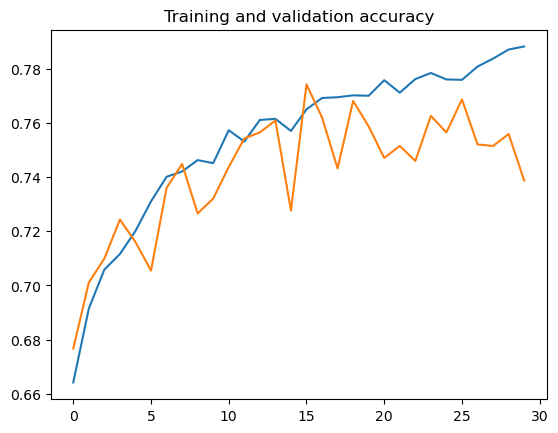

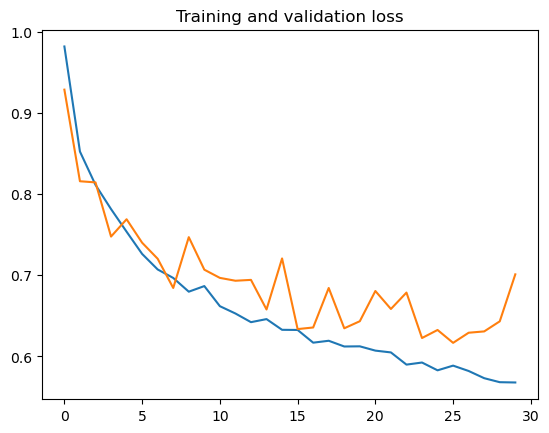

In [69]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')